In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request
import matplotlib as mpl
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.get_logger().setLevel('INFO')
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[1], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[1], enable=True)
import urllib
from dataclasses import dataclass
# import tensorflowjs as tfjs
# import tensorflow_decision_forests as tfdf
import json
from tqdm import tqdm
import seaborn as sns
import sys
np.random.seed(0)
urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True   
           })

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [3]:
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/insoluble.npz",
    "insoluble.npz",
)
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/soluble.npz",
    "soluble.npz",
)
with np.load("soluble.npz") as r:
    pos_data = r['arr_0']
with np.load("insoluble.npz") as r:
    neg_data = r['arr_0']

    


In [4]:
def split_train_test_data(pos, neg, test_size_pos=0.1, val_size=0.1, unlabeled_size=0.2, seed=None):
    np.random.seed(seed)
    np.random.shuffle(pos)
    np.random.shuffle(neg)
    from sklearn.model_selection import train_test_split
    pos, unlabeled_p, _, _ = train_test_split(pos, np.ones(pos.shape[0]),
                                                                        test_size=unlabeled_size, random_state=seed)
    X_test_negative, unlabeled_n, _, _ = train_test_split(neg, np.zeros(neg.shape[0]),
                                                                    test_size=unlabeled_size, random_state=seed)
    X_train_positive, X_test_positive, _, _ = train_test_split(pos, np.ones(pos.shape[0]),
                                                                                        test_size=test_size_pos, random_state=seed)
    X_train_positive, X_val_positive, _, _ = train_test_split(X_train_positive, np.ones(X_train_positive.shape[0]),
                                                                                    test_size=val_size, random_state=seed)
    X_unlabeled = np.concatenate([unlabeled_p, unlabeled_n])
    np.random.shuffle(X_unlabeled)
    
    print(X_train_positive.shape, X_val_positive.shape, X_test_positive.shape, X_test_negative.shape,  X_unlabeled.shape)
    return X_train_positive, X_val_positive, X_test_positive, X_test_negative, X_unlabeled

seed = 0
X_train_positive, X_val_positive, X_test_positive, X_test_negative, X_unlabeled = split_train_test_data(pos_data, neg_data, seed=seed)

print('Positive data:', pos_data.shape[0])
print('Negative data:', neg_data.shape[0])
print('Unlabeled data:', len(X_unlabeled))

(5692, 200) (633, 200) (703, 200) (7734, 200) (3691, 200)
Positive data: 8785
Negative data: 9668
Unlabeled data: 3691


In [5]:

# def build_fakes(n, data):
#     result = []
#     for _ in range(n):
#         # sample this many subsequences
#         k = np.clip(np.random.poisson(1), 0, len(data) - 2) + 2
#         idx = np.random.choice(range(len(data)), replace=False, size=k)                        
#         seq = []
#         lengths = []
#         # cut-up k into one new sequence
#         for i in range(k):
#             if np.argmin(data[idx[i]]) > 1:
#                 lengths.append(np.ceil(2 * np.random.randint(1, np.argmin(data[idx[i]])) / k).astype(int))
#                 j = np.random.randint(0, np.argmin(data[idx[i]]) - lengths[i])
#             else:
#                 lengths.append(1)
#                 j = 0
#             seq.append(data[idx[i]][j:j+lengths[i]])
#         # pad out    
#         seq.append([0] * (len(data[0]) - sum(lengths)))
#         # print(seq)
#         result.append(np.concatenate(seq))
#         # print(result)
#         # break
#     return np.array(result)
# sampled_vecs = build_fakes(pos_data.shape[0]*20, pos_data)




In [6]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(pos_data), 
                batch_size=256, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-4,
                drop_rate=0.2
               )

def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts/tf.reduce_sum(counts)

def build_model(L):
    inputs = tf.keras.Input(shape=(L,))
    input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    x = tf.keras.layers.Concatenate()([x, input_f])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[inputs, input_f], outputs=yhat, name='sol-rnn')
    return model

class F1Score(tf.keras.metrics.Metric):
  def __init__(self, name='F1Score', **kwargs):
    super(F1Score, self).__init__(name=name, **kwargs)
    self.f1score = self.add_weight(name='F1Score', initializer='zeros')
    self.count = self.add_weight(name='F1ScoreCount', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    import keras.backend as K
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)

    true_positives = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
    true_positives = tf.cast(true_positives, self.dtype)
    count_true_positives = tf.reduce_sum(true_positives)

    possible_positives = tf.cast(y_true, self.dtype)
    count_possible_positives = tf.reduce_sum(possible_positives)

    predicted_positives = tf.cast(y_pred, self.dtype)
    count_predicted_positives = tf.reduce_sum(predicted_positives)

    precision = count_true_positives / (count_predicted_positives + K.epsilon())
    recall = count_true_positives / (count_possible_positives + K.epsilon())
    f1_cal = 2*(precision*recall)/(precision + recall + K.epsilon())

    self.count.assign_add(1)
    a = 1.0 / self.count
    b = 1.0 - a
    self.f1score.assign(a*f1_cal+b*self.f1score)

  def result(self):
    return self.f1score

In [7]:
# from sklearn.model_selection import train_test_split
# X_train_positive, X_test_positive, y_train_positive, y_test_positive = train_test_split(X_positive, np.ones(X_positive.shape[0]),
#                                                                                         test_size=0.1, random_state=42)
# X_train_unlabeled, X_test_unlabeled, y_train_unlabeled, y_test_unlabeled = train_test_split(X_unlabeled, np.zeros(X_unlabeled.shape[0]),
#                                                                                         test_size=0.5, random_state=42)
# X_test_L = np.concatenate([X_test_positive, X_test_unlabeled])
# y_test_L = np.concatenate([np.ones(y_test_positive.shape[0]), np.zeros(X_test_unlabeled.shape[0])])


In [8]:
# X_test = np.concatenate([X_test_positive, X_negative])
# y_test = np.concatenate([np.ones(y_test_positive.shape[0]), np.zeros(X_negative.shape[0])])

In [9]:
def spy(X_p, X_u, spied_rate=0.2, seed=None):
    np.random.seed(seed)
    X = np.vstack([X_p, X_u])
    y = np.concatenate([np.ones(X_p.shape[0]), np.zeros(X_u.shape[0])])
    # Step 1. Infuse spies
    spie_mask = np.random.random(X_p.shape[0]) < spied_rate
    # Unknown mix + spies
    MS = np.vstack([X[y == 0], X[y == 1][spie_mask]]) # this is actual features for mix+spies
    MS_spies = np.hstack([np.zeros((y == 0).sum()), np.ones(spie_mask.sum())]) # this is actual labels for mix+spies
    # Positive with spies removed
    P = X[y == 1][~spie_mask]
    # Combo
    MSP = np.vstack([MS, P]) # this is mix+spies added to positives
    # Labels
    MSP_y = np.hstack([np.zeros(MS.shape[0]), np.ones(P.shape[0])]) # this label for is mix+spies added to positives
    shuffler = np.random.permutation(len(MSP))
    MSP = MSP[shuffler]
    MSP_y = MSP_y[shuffler]
    return MSP, MSP_y, MS, MS_spies

def find_RN_threshold(y_hat, y, initial_t=0.00001, spied_tolerance= 0.025):
    # Find optimal t
    t = initial_t
    while  y[np.squeeze(y_hat <= t)].sum()/y.sum()  <= spied_tolerance:
        t += 0.0001
    print('Optimal t is {0:.06}'.format(t))
    print('Positive group size {1}, captured spies {0:.02%}'.format(
        y[np.squeeze(y_hat > t)].sum()/y.sum(), (y_hat > t).sum()))
    print('Likely negative group size {1}, captured spies {0:.02%}'.format(
        y[np.squeeze(y_hat <= t)].sum()/y.sum(), (y_hat <= t).sum()))
    return t

(array([3691.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        5692.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

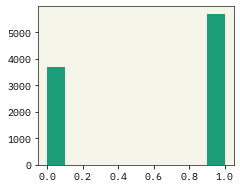

In [10]:
X = np.vstack([X_train_positive, X_unlabeled])
y = np.concatenate([np.ones(X_train_positive.shape[0]), np.zeros(X_unlabeled.shape[0])])
plt.hist(y)

(array([5104.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4279.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

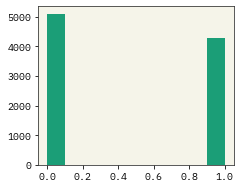

In [11]:
# np.random.seed(seed)
spied_rate = 0.25
X_train_with_spies, y_train_with_spies, true_X_train, true_y_train = spy(X_train_positive, X_unlabeled,
                                                                     seed=seed, spied_rate=spied_rate)
model = build_model(None)
plt.hist(y_train_with_spies)

In [12]:
def train_model(X_train_with_spies, y_train_with_spies, batch_size=64, L=None):
    model = build_model(L)
    decay_epochs = 50
    decay_steps = len(X_train_with_spies)  // 16 * decay_epochs
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
          config.lr, decay_steps, alpha=1e-3)
    opt = tf.optimizers.Adam(lr_decayed_fn)
    tf.keras.backend.clear_session()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='auc', patience=10, min_delta=1e-2, restore_best_weights=True)
    focal_loss  = tf.keras.losses.BinaryFocalCrossentropy(
                gamma=5, from_logits=False,  apply_class_balancing=True
                )
    model.compile(
            optimizer=opt,
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            # loss = focal_loss,
            metrics=[tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.BinaryAccuracy(threshold=0.5)],
            )
    print(f'\n\nModel l inputs with spies: Negative:{plt.hist(y_train_with_spies)[0][0]}, Positive:{plt.hist(y_train_with_spies)[0][-1]}\n\n')
    history = model.fit(
        [X_train_with_spies, np.array([counts_aa(xi) for xi in X_train_with_spies])] , y_train_with_spies,
#         validation_data=([X_test_L, np.array([counts_aa(xi) for xi in X_test_L])] , y_test_L),
        epochs=200,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1,
    )
    return model

In [13]:
def get_rn_unlabeled(y_prob, y_actual, rn_thresh, X):
    """For each negative instance, check if the predicted probability
    is lower than the rn threshold. If so, add to the rn set, otherwise,
    add to the unlabelled set.
    Parameters
    ----------
    y_prob: array-like {n_samples}
        Class probability predictions.
    y_actual: array-like {n_samples}
        Actual labelled class values.
    rn_thresh: float
        The threshold under which an instance is
        considered reliably negative.
    X: array-like {n_samples, n_features}
        Feature matrix.
    Returns
    -------
    rn_set: array-like {n_samples, n_features}
        The identified reliable negative instance set.
    new_unlabelled: array-like {n_samples, n_features}
        The remaining unlabelled instances.
    """

    rn_set = [X[i] for i in range(len(X)) if y_actual[i] == 0 and y_prob[i] < rn_thresh]
    new_unlabelled = [X[i] for i in range(len(X)) if y_actual[i] == 0 and y_prob[i] >= rn_thresh]

    return np.array(rn_set), np.array(new_unlabelled)




In [14]:
X_train_positive.shape

(5692, 200)



Model l inputs with spies: Negative:5104.0, Positive:4279.0


Epoch 1/200
587/587 [==============================] - 26s 23ms/step - loss: 0.7406 - auc: 0.5051 - binary_accuracy: 0.5112
Epoch 2/200
587/587 [==============================] - 14s 23ms/step - loss: 0.7112 - auc: 0.5011 - binary_accuracy: 0.5102
Epoch 3/200
587/587 [==============================] - 14s 23ms/step - loss: 0.7063 - auc: 0.4934 - binary_accuracy: 0.5060
Epoch 4/200
587/587 [==============================] - 14s 23ms/step - loss: 0.7003 - auc: 0.4974 - binary_accuracy: 0.5163
Epoch 5/200
587/587 [==============================] - 14s 23ms/step - loss: 0.6963 - auc: 0.5091 - binary_accuracy: 0.5242
Epoch 6/200
587/587 [==============================] - 14s 23ms/step - loss: 0.6969 - auc: 0.5031 - binary_accuracy: 0.5222
Epoch 7/200
587/587 [==============================] - 14s 23ms/step - loss: 0.6956 - auc: 0.5027 - binary_accuracy: 0.5210
Epoch 8/200
587/587 [==============================] - 14s 23ms/step

579/579 [==============================] - 13s 23ms/step - loss: 0.6439 - auc: 0.6163 - binary_accuracy: 0.6235
Epoch 32/200
579/579 [==============================] - 13s 23ms/step - loss: 0.6450 - auc: 0.6165 - binary_accuracy: 0.6201
Epoch 33/200
579/579 [==============================] - 13s 23ms/step - loss: 0.6442 - auc: 0.6179 - binary_accuracy: 0.6265
Epoch 34/200
579/579 [==============================] - 14s 23ms/step - loss: 0.6446 - auc: 0.6173 - binary_accuracy: 0.6230
Epoch 35/200
579/579 [==============================] - 13s 23ms/step - loss: 0.6416 - auc: 0.6234 - binary_accuracy: 0.6276
Epoch 36/200
579/579 [==============================] - 13s 23ms/step - loss: 0.6440 - auc: 0.6176 - binary_accuracy: 0.6246
Epoch 37/200
579/579 [==============================] - 13s 23ms/step - loss: 0.6419 - auc: 0.6220 - binary_accuracy: 0.6300
Epoch 38/200
579/579 [==============================] - 13s 23ms/step - loss: 0.6407 - auc: 0.6225 - binary_accuracy: 0.6281
Epoch 39/200


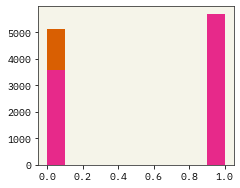

In [15]:
training = True
if training:
    model = train_model(X_train_with_spies, y_train_with_spies, batch_size=16)
    y_hat = model.predict([true_X_train, np.array([counts_aa(xi) for xi in true_X_train])])
    spied_tolerance = 0.95
    RN_t = find_RN_threshold(y_hat, true_y_train, spied_tolerance=spied_tolerance, initial_t=0.001)
    RN , new_X_unlabeled = get_rn_unlabeled(y_hat, true_y_train, RN_t, true_X_train)
    print(RN.shape)
    NP = np.concatenate([RN, X_train_positive])
    Labels = np.concatenate([np.zeros(RN.shape[0]), np.ones(X_train_positive.shape[0])])
    train_shuffled_indices = np.random.permutation(len(NP))
    NP = NP[train_shuffled_indices]
    Labels = Labels[train_shuffled_indices]
    inference_model = train_model(NP, Labels, batch_size=16)
    # serialize model to JSON
    inference_model_json = inference_model.to_json()
    with open("../saved_models/sol-rnn/spy_model.json", "w") as json_file:
        json_file.write(inference_model_json)
    # serialize weights to HDF5
    inference_model.save_weights("../saved_models/sol-rnn/spy_model_weights.h5")
    # saving RNs
    np.save('../saved_models/sol-rnn/spy_RNs.npy', RN)
else:
    # Inference model
    import keras
    # load json and create model
    json_file = open('../saved_models/sol-rnn/spy_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    inference_model = keras.models.model_from_json(loaded_model_json)
    best_accuracy_threshold = 0.95
    inference_model.compile(
        optimizer=opt,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    #     loss = focal_loss,
        metrics=[tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.BinaryAccuracy(threshold=best_accuracy_threshold), F1Score()],
        )

    # load weights into new model
    inference_model.load_weights("../saved_models/sol-rnn/spy_model_weights.h5")
    RN = np.load('../saved_models/sol-rnn/spy_RNs.npy')

In [16]:
X_test = np.concatenate([X_test_positive, X_test_negative])
y_test = np.concatenate([np.ones(X_test_positive.shape[0]), np.zeros(X_test_negative.shape[0])])
yhat_test =  inference_model.predict([X_test, np.array([counts_aa(xi) for xi in X_test])])

264/264 [==============================] - 6s 11ms/step


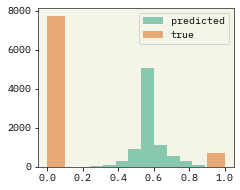

In [17]:
plt.hist(yhat_test, label='predicted', alpha=0.5, bins=10)
plt.hist(y_test, label='true', alpha=0.5, bins=10)
plt.legend()

Best Threshold=0.572384, G-Mean=0.636
Accuracy: 0.648
F1 Score: 0.499
AUC: 0.685


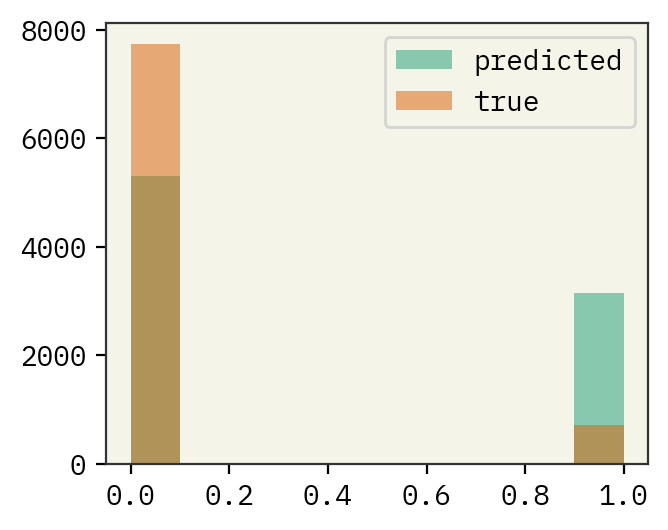

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

fpr, tpr, thresholds = roc_curve(y_test, yhat_test, drop_intermediate=False)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
best_accuracy_threshold = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
adjusted_y_hat_test = [1 if m>best_accuracy_threshold else 0 for m in yhat_test]
acc = accuracy_score(y_test, adjusted_y_hat_test, normalize=True)
print(f'Accuracy: {acc:.3f}')
f1 = f1_score(y_test, adjusted_y_hat_test, average='macro')
print(f'F1 Score: {f1:.3f}')
auc = roc_auc_score(y_test, yhat_test, average='macro')
print(f'AUC: {auc:.3f}')
plt.figure(dpi=200)
plt.hist(adjusted_y_hat_test, label='predicted', alpha=0.5, bins=10)
plt.hist(y_test, label='true', alpha=0.5, bins=10)
plt.legend()


Best ghostml Threshold=%f, 0.69
Accuracy: 0.867
F1 Score: 0.589
AUC: 0.685


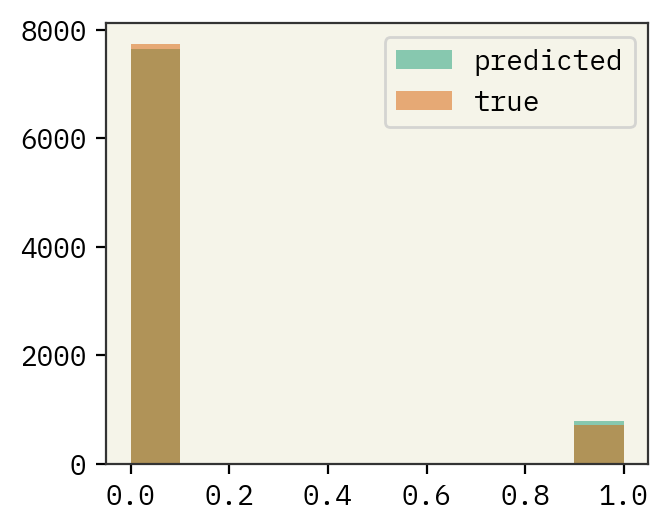

In [19]:
import ghostml
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# train_probs = model_2.predict([NP, np.array([counts_aa(xi) for xi in NP])])
thresholds = np.round(np.arange(0.1,0.95,0.005),2)
threshold1 = ghostml.optimize_threshold_from_predictions(y_test, yhat_test[:,0], thresholds, ThOpt_metrics = 'Kappa')
print(f'\nBest ghostml Threshold=%f, {threshold1}')
best_accuracy_threshold = threshold1
adjusted_y_hat_test = [1 if m>best_accuracy_threshold else 0 for m in yhat_test]
acc = accuracy_score(y_test, adjusted_y_hat_test, normalize=True)
print(f'Accuracy: {acc:.3f}')
f1 = f1_score(y_test, adjusted_y_hat_test, average='macro')
print(f'F1 Score: {f1:.3f}')
auc = roc_auc_score(y_test, yhat_test, average='macro')
print(f'AUC: {auc:.3f}')

plt.figure(dpi=200)
plt.hist(adjusted_y_hat_test, label='predicted', alpha=0.5, bins=10)
plt.hist(y_test, label='true', alpha=0.5, bins=10)
plt.legend()

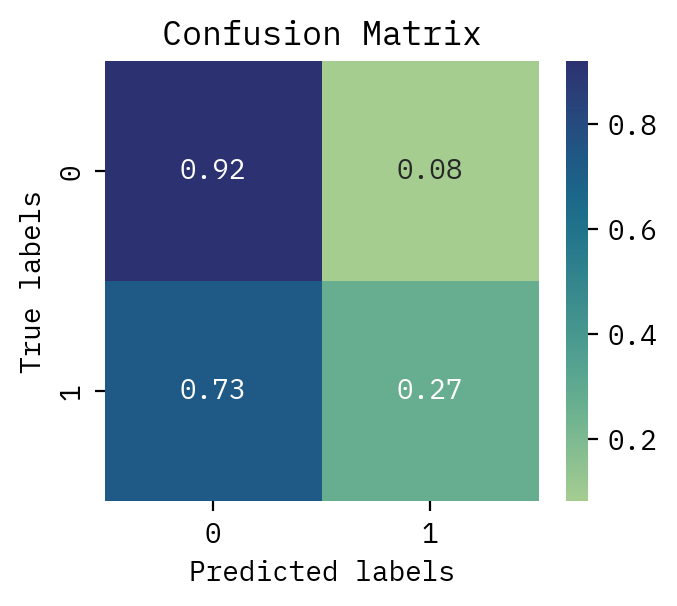

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, adjusted_y_hat_test, normalize='true')
# fig = plt.figure(dpi= 200)
plt.figure(dpi=200)
sns.heatmap(np.round(cm, 2), annot=True, fmt='g', ax=plt.gca(), cmap="crest");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax=plt.gca()
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 